In [1]:
#import libraries
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
sns.set()

In [2]:
#import data
data = pd.read_csv('shop.csv',encoding='latin-1')

#preprocess data for product brands
#get list of headers for product brand names
headers = [i for i in list(data.head(0))[1:] if i[-5:] == 'brand']

#search for all brand names containing the term 'bio'
bio_search = ['Bio', 'bio', 'BIO']

for i in headers:
    #replace all brand names containing the term 'no brand' with 1
    data.loc[data[i].str.contains('no brand',na=False), i] = 1
    #replace all brand names containing the term 'bio' with 2
    data.loc[data[i].str.contains('|'.join(bio_search),na=False), i] = 2
    #replace every other brand name with 3
    data.loc[data[i].str.contains('.*?',na=False), i] = 3

#take a peak at the data
data.head()

,Grocery store brand,Area,Apple 1 brand,Apple 1 price,Apple 2 brand,Apple 2 price,Apple 3 brand,Apple 3 price,Banana 1 brand,Banana 1 price,...,Eggs 2 brand,Eggs 2 price,Eggs 3 brand,Eggs 3 price,Chicken 1 brand,Chicken 1 price,Chicken 2 brand,Chicken 2 price,Chicken 3 brand,Chicken 3 price
0,1,1,3,2.49,3,2.49,1,1.40,1,1.09,...,3,2.02,1,3.30,3,6.48,NaN,0.00,NaN,0.00
1,3,2,3,2.72,3,1.39,3,2.99,1,1.09,...,2,3.30,3,1.29,3,6.98,3,7.48,NaN,NaN
2,4,7,3,1.99,3,2.99,3,1.99,1,1.09,...,3,2.38,2,4.98,1,6.98,NaN,NaN,NaN,NaN
3,4,4,3,1.99,3,2.93,3,1.99,3,0.88,...,3,3.38,3,1.55,3,9.99,2,25.99,3,9.99
4,3,6,3,1.79,3,1.39,3,2.74,2,1.65,...,3,2.03,3,1.55,2,19.99,3,6.48,NaN,NaN


In [3]:
#define numerical code for base product types and multipliers
store_dict = { 1: 'Lidl', 2: 'Rewe', 3: 'Aldi', 4: 'Edeka' }

area_dict = { 1:"Mitte",2:"Schoneberg",3:"Neukooln",4:"Kreuzberg",5:"Friedrichshain",
             6:"Prenzlauer Berg",7:"Tiergarten",8:"Alt-Tempelhof",9:"Wedding",
             10:"Gesundbrunnen",11:"Moabit",12:"Rummelsburg",13:"Lichtenberg" }

type_dict = {1:"Apple",2:"Banana",3:"Tomatoes",4:"Potatos",5:"Flour",
             6:"Rice",7:"Milk",8:"Butter",9:"Eggs",10:"Chicken"}

brand_dict = {1:"No brand",2:"Bio brand",3:"Other"}

In [4]:
#preprocess data into lists of length: number of observed prices collected
prices = []
stores = []
types = []
areas = []
brands = []

for i in range(1,11):
    product = type_dict[i]
    price1 = data[[product+' 1 price',product+' 1 brand','Grocery store brand','Area']].dropna() 
    price2 = data[[product+' 2 price',product+' 2 brand','Grocery store brand','Area']].dropna() 
    price3 = data[[product+' 3 price',product+' 3 brand','Grocery store brand','Area']].dropna()
    
    product_prices = price1[product+' 1 price'].values.tolist() + price2[product+' 2 price'].values.tolist() + price3[product+' 3 price'].values.tolist()
    product_stores = price1['Grocery store brand'].values.tolist() + price2['Grocery store brand'].values.tolist() + price3['Grocery store brand'].values.tolist()
    product_type = len(product_prices)*[i]
    product_area = price1['Area'].values.tolist() + price2['Area'].values.tolist() + price3['Area'].values.tolist()
    product_brand = price1[product+' 1 brand'].values.tolist() + price2[product+' 2 brand'].values.tolist() + price3[product+' 3 brand'].values.tolist()
    
    prices += product_prices
    stores += product_stores
    types += product_type
    areas += product_area
    brands += product_brand

#take a peak at the preprocessed data
print(prices[0:10])
print(stores[0:10])
print(types[0:10])
print(areas[0:10])
print(brands[0:10])
    

[2.49, 2.72, 1.99, 1.99, 1.79, 3.13, 1.99, 4.38, 1.52, 1.99]
[1, 3, 4, 4, 3, 1, 4, 3, 2, 4]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 2, 7, 4, 6, 1, 1, 3, 4, 3]
[3, 3, 3, 3, 3, 2, 3, 2, 3, 3]


In [83]:
#Build the stan model
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  

    int<lower=1> N;           // number of observed prices collected
    int<lower=1> T;           // number of different types of products
    int<lower=1> S;           // number of different types of stores
    int<lower=1> A;           // number of different types of areas
    int<lower=1> B;           // number of different types of brands
    
    // data collected
    real<lower=0> prices[N];  
    int types[N];             
    int stores[N];             
    int areas[N]; 
    int brands[N]; 
    
    // fixed prior hyperparameters
    real<lower=0> alpha;      
    real<lower=0> beta;       
    
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {

    real<lower=0> base_price[T];       //vector containing base prices (number of base prices == number of product types)
    real<lower=0> multiplier_store[S]; //vector containing store multipliers
    real<lower=0> multiplier_area[A];  //vector containing area multipliers
    real<lower=0> multiplier_brand[B];  //vector containing brand multipliers
    real<lower=0> sigma;              //random noise when sampling from the normal distribution for observed prices
    
}


// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {

    sigma ~ gamma(alpha, beta);      //generate random noise for normal distribution
    
    for (i in 1:T) {
        base_price[types[i]] ~ cauchy(1.5, 2);         //generate base price
    };
    
    for (i in 1:S) {
        multiplier_store[stores[i]] ~ cauchy(1, 0.7);  //generate store multiplier
    };
    
    for (i in 1:A) {
        multiplier_area[areas[i]] ~ cauchy(1, 0.7);    //generate area multiplier
    };
    
    for (i in 1:B) {
        multiplier_brand[brands[i]] ~ cauchy(1, 0.7);    //generate brand multiplier
    };
    
    for(i in 1:N) {
        prices[i] ~ normal(base_price[types[i]] * multiplier_store[stores[i]] * multiplier_area[areas[i]] * multiplier_brand[brands[i]], sigma); //likelihood function
  }
  
}

"""

In [84]:
#compile the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7c5195ec8ccd5cb3e87a60dfe62ebb75 NOW.


In [85]:
#stan input data
stan_data = {
                'prices': prices,
                'types': types,
                'stores': stores,
                'areas': areas,
                'brands': brands,
                'N': len(prices), 
                'T': len(set(types)),
                'S': len(set(stores)),
                'A': len(set(areas)),
                'B': len(set(brands)),
                'alpha': 1.5,  
                'beta': 7
            }

In [86]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
stan_results = stan_model.sampling(data=stan_data)
print(stan_results)

Inference for Stan model: anon_model_7c5195ec8ccd5cb3e87a60dfe62ebb75.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]         2.17    0.02   0.47   1.35   1.84   2.12   2.45   3.17    891    1.0
base_price[2]         1.27    0.01   0.31   0.75   1.04   1.23   1.45   1.97    962    1.0
base_price[3]         3.27    0.03   0.75   1.99   2.73   3.18   3.72   4.91    882    1.0
base_price[4]         1.14  9.2e-3   0.29   0.67   0.94   1.11   1.32   1.78    980    1.0
base_price[5]         1.07  8.4e-3   0.28   0.61   0.88   1.03   1.23   1.71   1090    1.0
base_price[6]         2.89    0.02   0.67   1.74   2.41   2.82   3.31   4.35    904    1.0
base_price[7]         0.96  8.2e-3   0.25   0.54   0.78   0.93   1.12   1.55    963    1.0
base_price[8]         4.23    0.03   0.96    2.6   3.55   4.11   4.84   6.34    875

In [88]:
# Extract the generated samples from the stan model
posterior_samples = stan_results.extract()

### Modeling Assumptions

The half-cauchy distribution was chosen as the generative prior for the base prices, store multipliers, area multipliers, and brand multipliers. This choice was motivated by the cauchy's fat tails, which represent a broad prior distribution where the probabilities assigned to values moving away from the mean approach 0 at a slower rate.

The store, area, and brand multipliers are centered around 1 to represent an average multiplier effect of 1. The scale parameter chosen was 0.7 to represent an averagely broad prior. 

The base price prior half-cauchy was centered around 1.5 since the data was cleaned to only contain stores from Berlin, and so a stable currency unit of Euro was safely assumed. Furthermore, the products consist of everyday goods that one would not expect to exceed 10 euros at the highest. The scale parameter chosen was 2 to represent a broader prior, since there can be a large difference in price range between meat and vegetables. 

The normal distribution was chosen as the likelihood function, with the equation of $f(x) = $base_price $ \times $ multiplier_store $ \times $ multiplier_area $ \times $ multiplier_brand as the mean, and $\sigma$ as the standard deviation. We expect the observed prices to obey the Central Limit Theorem, which would make the normal distribution a good choice. The noise variable, $\sigma$, was generated from a gamma distribution with $\alpha=1.5$ and $\beta=7$. This distribution had mean of 0.2143 and a standard deviation of 0.175, which I believed was a good representation of the uncertainty within the noise levels.

### Other Assumptions

<b>Human error</b>

Some variation in the data will be purely due to human error. The data was collected by different individuals who probably went about the process with different methodologies. Furthermore, while instructions were given to record prices according to set units (1kg, 1 dozen, etc.), there is a high chance of omitting this step. Some of the data could also have been falsely constructed since there is no guarantee that the individuals actually carried out the data collection process.

<b>Product brand categorization</b>

The product brands were separated into 3 distinct categories: No brand, Bio brand, and Other. It was assumed that all brands that contained the term "bio" would most likely share similar traits, and so they were placed within the same category. Due to the large variety of other brands, the "non-bio" brands were categorized together as "Other", which is most certainly an over-generalization of the data. Products with no brand recorded were categorized as "No brand".


### Questions to answer
● What is the basic average price for each product?

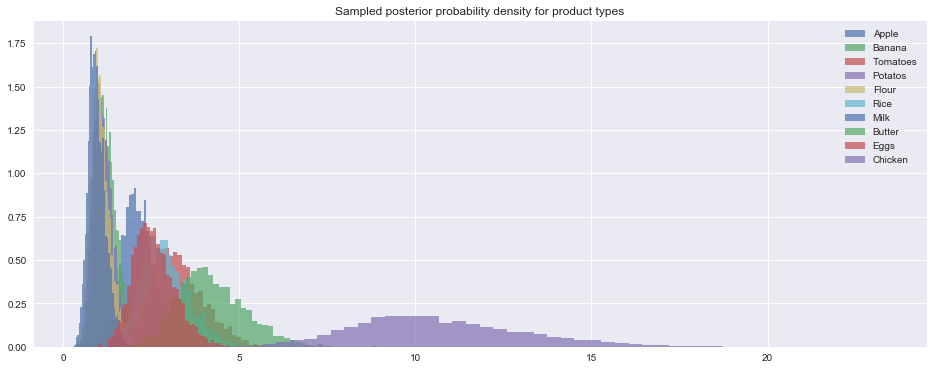

,Label,Mean,Posterior 95% confidence interval,Standard Error
0,Apple,2.17,"[1.3492458977100026, 3.162575776762137]",0.47
1,Banana,1.27,"[0.7499940957868625, 1.9707530183460489]",0.31
2,Tomatoes,3.27,"[1.9862708252062764, 4.908867958395163]",0.75
3,Potatos,1.14,"[0.6711035347194378, 1.7810612135920565]",0.29
4,Flour,1.07,"[0.6148647938107232, 1.7051929636281271]",0.28
5,Rice,2.89,"[1.745956577960827, 4.3526133377586245]",0.67
6,Milk,0.96,"[0.542958582073606, 1.5466058958416689]",0.25
7,Butter,4.23,"[2.60713261102745, 6.340711619185721]",0.96
8,Eggs,2.59,"[1.5906415250531818, 3.9070481150865564]",0.60
9,Chicken,10.67,"[6.58679851784204, 15.958343016975801]",2.42


In [89]:
#Posterior probability density for different product types
type_df = pd.DataFrame(columns=['Label','Mean','Posterior 95% confidence interval','Standard Error'])
plt.figure(figsize = (16,6))
plt.title('Sampled posterior probability density for product types')
for i in range(len(type_dict)):
    plt.hist(posterior_samples['base_price'][:,i],bins=50, density=True, alpha = 0.7, label = type_dict[i+1])
    type_df.loc[i] = (type_dict[i+1],
                      round(np.mean(posterior_samples['base_price'][:,i]),2),
                      np.percentile(posterior_samples['base_price'][:,i], [2.5, 97.5]),
                      round(np.std(posterior_samples['base_price'][:,i], ddof=1),2))
plt.legend()
plt.show()
type_df

● How much does each of the following factors modify the basic price of the product (up or down)?

○ Brand of the product.

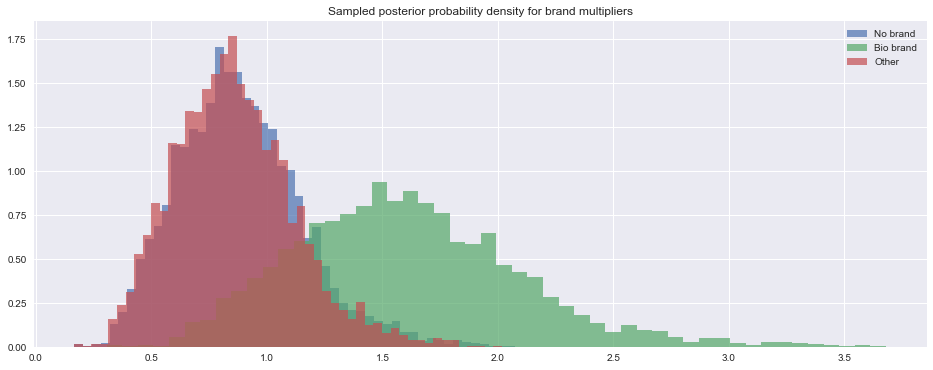

,Label,Mean,Posterior 95% confidence interval,Standard Error
0,No brand,0.89,"[0.4289754349616492, 1.5112206570961664]",0.27
1,Bio brand,1.60,"[0.7807323112272733, 2.6923204672803607]",0.49
2,Other,0.86,"[0.4170854886936737, 1.4505228437240378]",0.26


In [90]:
#Posterior probability density for different brand types
brand_df = pd.DataFrame(columns=['Label','Mean','Posterior 95% confidence interval','Standard Error'])
plt.figure(figsize = (16,6))
plt.title('Sampled posterior probability density for brand multipliers')
for i in range(len(brand_dict)):
    plt.hist(posterior_samples['multiplier_brand'][:,i],bins=50, density=True, alpha = 0.7, label = brand_dict[i+1]) 
    brand_df.loc[i] = (brand_dict[i+1],
                       round(np.mean(posterior_samples['multiplier_brand'][:,i]),2),
                       np.percentile(posterior_samples['multiplier_brand'][:,i],[2.5, 97.5]),
                       round(np.std(posterior_samples['multiplier_brand'][:,i], ddof=1),2))
plt.legend()
plt.show()
brand_df

From the graph and table above, we see that Bio brand has the highest mean multiplier effect of 1.60, whereas No brand and Other brands have a virtually similar mean multiplier effect of 0.89 and 0.86 respectively. This can also be visually inferred through the graph - the posterior distributions for No brand and Other have a high area of overlap.

In [98]:
print('T-tests for the brand multipliers:')

for i in range(len(brand_dict)):
    for j in range(len(brand_dict)):
        if i==j: continue
        
        z, p = sts.ttest_ind(posterior_samples['multiplier_brand'][:,j],posterior_samples['multiplier_brand'][:,i])
        if p > 0.05:
            print(brand_dict[i+1] + ' is not significantly more expensive than' + brand_dict[j+1])
        if p < 0.05: 
            if z < 0: 
                print(brand_dict[i+1] + ' is significantly more expensive than ' + brand_dict[j+1])
            if z > 0:
                print(brand_dict[i+1] + ' is significantly cheaper than ' + brand_dict[j+1])   

T-tests for the brand multipliers:
No brand is significantly cheaper than Bio brand
No brand is significantly more expensive than Other
Bio brand is significantly more expensive than No brand
Bio brand is significantly more expensive than Other
Other is significantly cheaper than No brand
Other is significantly cheaper than Bio brand


○ Brand of the grocery store.

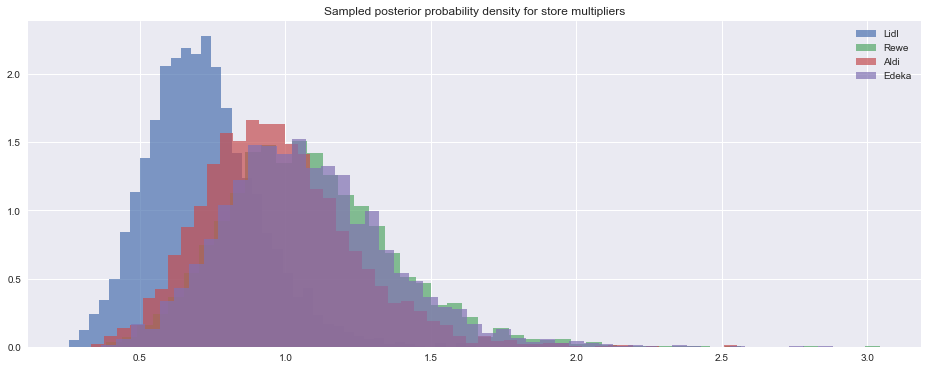

,Label,Mean,Posterior 95% confidence interval,Standard Error
0,Lidl,0.72,"[0.39135053828963273, 1.145289972071517]",0.19
1,Rewe,1.08,"[0.5930721067094563, 1.7219251209448216]",0.29
2,Aldi,0.97,"[0.5351883347630948, 1.5357320718311804]",0.26
3,Edeka,1.07,"[0.5879480203474513, 1.6875388867760923]",0.29


In [99]:
#Posterior probability density for different store types
store_df = pd.DataFrame(columns=['Label','Mean','Posterior 95% confidence interval','Standard Error'])
plt.figure(figsize = (16,6))
plt.title('Sampled posterior probability density for store multipliers')
for i in range(len(store_dict)):
    plt.hist(posterior_samples['multiplier_store'][:,i],bins=50, density=True, alpha = 0.7, label = store_dict[i+1]) 
    store_df.loc[i] = (store_dict[i+1],round(np.mean(posterior_samples['multiplier_store'][:,i]),2),np.percentile(posterior_samples['multiplier_store'][:,i], [2.5, 97.5]),round(np.std(posterior_samples['multiplier_store'][:,i], ddof=1),2))
plt.legend()
plt.show()
store_df

From the graph and table above, we see that Rewe and  Edeka have the highest mean multipliers of 1.08 and 1.07 respectively, whereas Lidl has the lowest mean multiplier of 0.72.

There is a high overlap area between the posterior distributions for Rewe, Edeka, and Aldi, whereas Lidl's distribution mean can be observed to peak to the left of the other 3 distributions. 

In [100]:
print('T-tests for the store multipliers:')

for i in range(len(store_dict)):
    for j in range(len(store_dict)):
        if i==j: continue
        
        z, p = sts.ttest_ind(posterior_samples['multiplier_store'][:,j],posterior_samples['multiplier_store'][:,i])
        if p > 0.05:
            print(store_dict[i+1] + ' is not significantly more expensive than ' + store_dict[j+1])
        if p < 0.05: 
            if z < 0: 
                print(store_dict[i+1] + ' is significantly more expensive than ' + store_dict[j+1])
            if z > 0:
                print(store_dict[i+1] + ' is significantly cheaper than ' + store_dict[j+1]) 

T-tests for the store multipliers:
Lidl is significantly cheaper than Rewe
Lidl is significantly cheaper than Aldi
Lidl is significantly cheaper than Edeka
Rewe is significantly more expensive than Lidl
Rewe is significantly more expensive than Aldi
Rewe is not significantly more expensive than Edeka
Aldi is significantly more expensive than Lidl
Aldi is significantly cheaper than Rewe
Aldi is significantly cheaper than Edeka
Edeka is significantly more expensive than Lidl
Edeka is not significantly more expensive than Rewe
Edeka is significantly more expensive than Aldi


○ Geographical location of the grocery store.

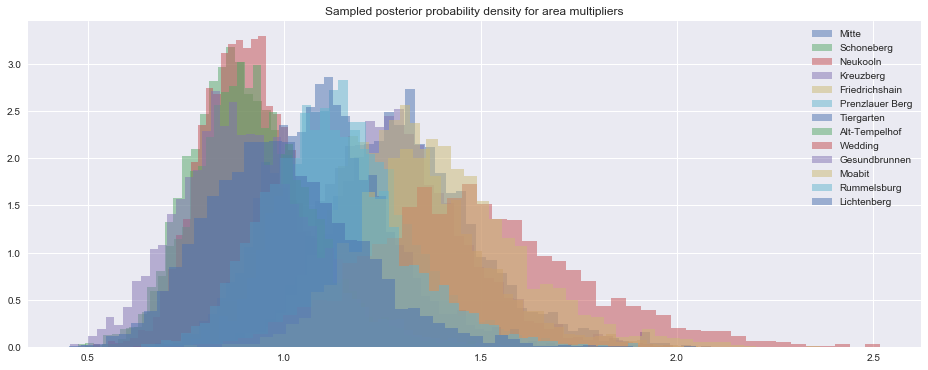

,Label,Mean,Posterior 95% confidence interval,Standard Error
0,Mitte,1.32,"[1.0190909835186404, 1.7286391492890913]",0.18
1,Schoneberg,0.90,"[0.6521564402537261, 1.2209006288385988]",0.14
2,Neukooln,0.92,"[0.69765425852583, 1.1973346593351333]",0.13
3,Kreuzberg,1.29,"[0.985661704684716, 1.684046122082647]",0.17
4,Friedrichshain,1.30,"[0.9970416973838953, 1.7060082486675912]",0.18
5,Prenzlauer Berg,1.16,"[0.8817167128311205, 1.5189216447033138]",0.16
6,Tiergarten,1.12,"[0.8341644230801579, 1.4881559553269486]",0.16
7,Alt-Tempelhof,0.93,"[0.6673330895318058, 1.2536873646793893]",0.15
8,Wedding,1.48,"[1.0056344988557337, 2.0689253888704733]",0.27
9,Gesundbrunnen,0.90,"[0.6056233438688825, 1.284809136665662]",0.17


In [94]:
#Posterior probability density for different areas
area_df = pd.DataFrame(columns=['Label','Mean','Posterior 95% confidence interval','Standard Error'])
plt.figure(figsize = (16,6))
plt.title('Sampled posterior probability density for area multipliers')
for i in range(len(area_dict)):
    plt.hist(posterior_samples['multiplier_area'][:,i],bins=50, density=True, alpha = 0.5, label = area_dict[i+1]) 
    area_df.loc[i] = (area_dict[i+1],round(np.mean(posterior_samples['multiplier_area'][:,i]),2),np.percentile(posterior_samples['multiplier_area'][:,i], [2.5, 97.5]),round(np.std(posterior_samples['multiplier_area'][:,i], ddof=1),2))
plt.legend()
plt.show()
area_df

From the graph and the table, we see that most of the neighborhood multiplier posterior distributions overlap, and the multiplier means lie within the range of 0.89 (Schoneberg & Gesundbrunnen) on the low end, and 1.47 (Wedding) on the high end. 

In [95]:
print('T-tests for the neigborhood multipliers:')

for i in range(len(area_dict)):
    for j in range(len(area_dict)):
        if i==j: continue
        
        z, p = sts.ttest_ind(posterior_samples['multiplier_area'][:,j],posterior_samples['multiplier_area'][:,i])
        if p > 0.05:
            print(area_dict[i+1] + ' is not significantly more expensive than ' + area_dict[j+1])
        if p < 0.05: 
            if z < 0: 
                print(area_dict[i+1] + ' is significantly more expensive than ' + area_dict[j+1])
            if z > 0:
                print(area_dict[i+1] + ' is significantly cheaper than ' + area_dict[j+1]) 

T-tests for the neigborhood multipliers:
Mitte is significantly more expensive than Schoneberg
Mitte is significantly more expensive than Neukooln
Mitte is significantly more expensive than Kreuzberg
Mitte is significantly more expensive than Friedrichshain
Mitte is significantly more expensive than Prenzlauer Berg
Mitte is significantly more expensive than Tiergarten
Mitte is significantly more expensive than Alt-Tempelhof
Mitte is significantly cheaper than Wedding
Mitte is significantly more expensive than Gesundbrunnen
Mitte is significantly cheaper than Moabit
Mitte is significantly more expensive than Rummelsburg
Mitte is significantly more expensive than Lichtenberg
Schoneberg is significantly cheaper than Mitte
Schoneberg is significantly cheaper than Neukooln
Schoneberg is significantly cheaper than Kreuzberg
Schoneberg is significantly cheaper than Friedrichshain
Schoneberg is significantly cheaper than Prenzlauer Berg
Schoneberg is significantly cheaper than Tiergarten
Schon

● How strong is each of the brand and location effects? Which have the greatest influence on
price variation between shops?


The strength of the brand and location effects have been illustrated above, with a higher mean multiplier representing a stronger multiplier effect, and a lower mean multiplier representing a weaker multiplier effect. The mean is used to represent the multiplier effect with an understanding that the certainty of the mean value varies with the distribution variance, and so the multiplier effect differences have to be interpreted within the appropriate context of variance and 95% CIs as shown in the tables above. The summary is as follows:

Brand multiplier

- Highest multiplier mean for brand: Bio brands (1.60)
- Lowest multiplier mean for brand: Other (0.86)
- The range of the means is 1.60 - 0.86 = 0.74. This means there is an average of 74% difference in mean price depending on whether you buy no brand, bio brand, or other.

Store multiplier

- Highest multiplier mean for store: Rewe (1.08)
- Lowest multiplier mean for store: Lidl (0.72)
- The range of the means is 1.08 - 0.72 = 0.36. This means there is an average of 36% difference in mean price depending on whether you buy from Lidl, Rewe, Aldi or Edeka.

Area multiplier

- Highest multiplier mean for area: Wedding (1.48)
- Lowest multiplier mean for area: Schoneberg & Gesundbrunnen (0.90)
- The range of the means is 1.48 - 0.90 = 0.58. This means there is an average of 58% difference in mean price depending on which neighborhood the product is located within.


Assuming that the means of the various distributions can be safely generalized to represent the multiplier effect (despite differing variances), the brand multiplier has the greatest influence on price variation between shops (range of means = 0.74), whereas the store multiplier has the lowest influence on price variation between shops (range of means = 0.36).



● Does price variation by geographical location correlate with variation in rental prices in Berlin, or
not?  There is a <a href="https://www.immobilienscout24.de/content/dam/is24/ibw/dokumente/mietmap-berlin-2017.jpg">2017 map of rental prices by U­Bahn and S­Bahn station here</a> .

In [101]:
area_df[['Label','Mean']]

#rental prices were gathered by locating the nearest train station to the corresponding location in the map,
#then extracting the prices from the nearest 5 stations. In locations with lower train station density, less prices were obtained.
mitte = [1044,1048,1154,1090,1002]
schoneberg = [797,705,778,855,844]
neukooln = [812,872,820,743,801]
kreuzberg = [865,854,895,941,908]
friedrichschain = [976,877,846,842,942]
prenzauler_berg = [856,893]
tiergarten = [1048,957,859]
alt_tempelhof = [743,755,730]
wedding = [769,778,773]
gesundbrunnen = [802,893,739,746,719]
moabit = [932,957]
rummelsburg = [774,804,702]
lichtenburg = [739,736,752]

rental_prices = [np.mean(mitte),np.mean(schoneberg),np.mean(neukooln),np.mean(kreuzberg),np.mean(friedrichschain),
                 np.mean(prenzauler_berg), np.mean(tiergarten),np.mean(alt_tempelhof),np.mean(wedding),
                 np.mean(gesundbrunnen),np.mean(moabit),np.mean(rummelsburg),np.mean(lichtenburg)]

price_compare = area_df[['Label','Mean']]
price_compare['Rental price means'] = np.round(rental_prices,2)
price_compare

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Label,Mean,Rental price means
0,Mitte,1.32,1067.60
1,Schoneberg,0.90,795.80
2,Neukooln,0.92,809.60
3,Kreuzberg,1.29,892.60
4,Friedrichshain,1.30,896.60
5,Prenzlauer Berg,1.16,874.50
6,Tiergarten,1.12,954.67
7,Alt-Tempelhof,0.93,742.67
8,Wedding,1.48,773.33
9,Gesundbrunnen,0.90,779.80


Pearson Correlation Coefficient: 0.5283170763686273


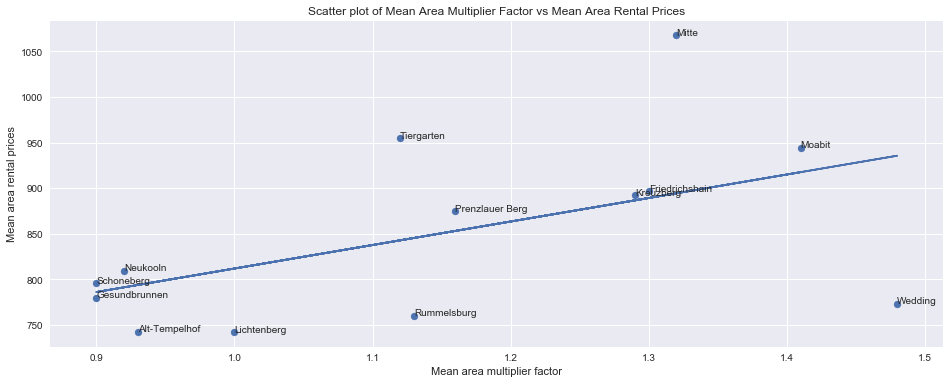

In [102]:
print('Pearson Correlation Coefficient:',price_compare['Mean'].corr(price_compare['Rental price means']))
x = price_compare['Mean']
y = price_compare['Rental price means']
b, m = np.polynomial.polynomial.polyfit(x, y, 1)
area_names = [v for k,v in area_dict.items()]

plt.figure(figsize = (16,6))
plt.scatter(x,y)
plt.plot(x, b + m * x, '-')
plt.xlabel("Mean area multiplier factor")
plt.ylabel("Mean area rental prices")
plt.title("Scatter plot of Mean Area Multiplier Factor vs Mean Area Rental Prices")
for i, txt in enumerate(area_names):
    plt.annotate(txt, (x[i], y[i]))

The mean area rental prices and mean area multipliers show a positive correlation, with a Pearson Correlation Coefficient of 0.53. 

Some of the more prominent outliers include Wedding and Mitte, whose x,y points are (1.48,773.33) and (1.32, 1067.60) respectively. These two neighborhoods lie on opposite ends of the spectrum - with Wedding having an unusually low mean rental price given its corresponding multiplier effect, and Mitte having an unusually high rental price given its corresponding multipler effect. 

While the positive correlation between area multiplier factor and area rental price seems intuitive, it has to be noted that the data collection method for the rental prices were rather crude. I manually picked prices from the map based on googling train stations that were closest to a given neighborhood and selected the 5 closest neighboring stations to get the neighborhood's mean rental price. In cases where the train stations were rather isolated from other stations (low train station density), I would select less stations for the calculation of the average rental price.

### Metadata
#### Store: EDEKA, Annenstraße

Visited: 10/29/2018 13:55:00

<img src="store1.jpg">


#### Store: ALDI, Ostseestraße 25

Visited: 10/27/2018 13:24:06

<img src="store2.jpg">